In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
base_img_rgb = '1.tif'
next_img_path = '2.tif'

In [4]:
base_img_rgb = cv2.imread(base_img_rgb)
base_img = cv2.GaussianBlur(cv2.cvtColor(base_img_rgb, cv2.COLOR_BGR2GRAY), (5,5), 0)

#use SIFT feature detector
detector = cv2.xfeatures2d.SIFT_create()

# Parameters for nearest-neighbor matching
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

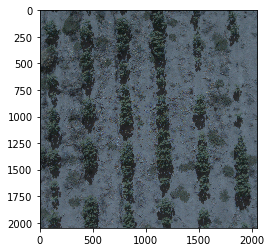

In [5]:
plt.imshow(base_img_rgb)

In [6]:
base_features, base_descs = detector.detectAndCompute(base_img, None)

In [7]:
# Read in the next image...
next_img_rgb = cv2.imread(next_img_path)
next_img = cv2.GaussianBlur(cv2.cvtColor(next_img_rgb,cv2.COLOR_BGR2GRAY), (5,5), 0)

# Find points in the next frame
next_features, next_descs = detector.detectAndCompute(next_img, None)

In [8]:
matches = matcher.knnMatch(next_descs, trainDescriptors=base_descs, k=2)

In [9]:
def filter_matches(matches, ratio = 0.75):
    filtered_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            filtered_matches.append(m[0])

    return filtered_matches

In [10]:
matches_subset = filter_matches(matches)

In [11]:
kp1 = []
kp2 = []
for match in matches_subset:
    kp1.append(base_features[match.trainIdx])
    kp2.append(next_features[match.queryIdx])

p1 = np.array([k.pt for k in kp1])
p2 = np.array([k.pt for k in kp2])

H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
print('{:d} / {:d}  inliers/matched'.format(np.sum(status), len(status)))

1019 / 1339  inliers/matched


In [12]:
def findDimensions(image, homography):
    base_p1 = np.ones(3, np.float32)
    base_p2 = np.ones(3, np.float32)
    base_p3 = np.ones(3, np.float32)
    base_p4 = np.ones(3, np.float32)

    (y, x) = image.shape[:2]

    base_p1[:2] = [0,0]
    base_p2[:2] = [x,0]
    base_p3[:2] = [0,y]
    base_p4[:2] = [x,y]

    max_x = None
    max_y = None
    min_x = None
    min_y = None

    for pt in [base_p1, base_p2, base_p3, base_p4]:
        hp = np.matrix(homography, np.float32) * np.matrix(pt, np.float32).T
        hp_arr = np.array(hp, np.float32)
        normal_pt = np.array([hp_arr[0]/hp_arr[2], hp_arr[1]/hp_arr[2]], np.float32)

        if ( max_x == None or normal_pt[0,0] > max_x ):
            max_x = normal_pt[0,0]

        if ( max_y == None or normal_pt[1,0] > max_y ):
            max_y = normal_pt[1,0]

        if ( min_x == None or normal_pt[0,0] < min_x ):
            min_x = normal_pt[0,0]

        if ( min_y == None or normal_pt[1,0] < min_y ):
            min_y = normal_pt[1,0]

    min_x = min(0, min_x)
    min_y = min(0, min_y)
    return (min_x, min_y, max_x, max_y)

In [13]:
H = H / H[2,2]
H_inv = np.linalg.inv(H)

(min_x, min_y, max_x, max_y) = findDimensions(next_img, H_inv)

# Adjust max_x and max_y by base img size
max_x = max(max_x, base_img.shape[1])
max_y = max(max_y, base_img.shape[0])

move_h = np.matrix(np.identity(3), np.float32)

if ( min_x < 0 ):
    move_h[0,2] += -min_x
    max_x += -min_x

if ( min_y < 0 ):
    move_h[1,2] += -min_y
    max_y += -min_y

print("Homography: \n", H)
print("Inverse Homography: \n", H_inv)
print("Min Points: ", (min_x, min_y))

mod_inv_h = move_h * H_inv

img_w = int(math.ceil(max_x))
img_h = int(math.ceil(max_y))

Homography: 
 [[ 1.02474209e+00  1.14895976e-02 -5.20907634e+01]
 [ 1.56349258e-02  1.04816348e+00  7.30767277e+02]
 [ 2.21158684e-06  8.29049092e-06  1.00000000e+00]]
Inverse Homography: 
 [[ 9.75898312e-01 -1.11640648e-02  5.89936213e+01]
 [-1.31281337e-02  9.59746334e-01 -7.02035070e+02]
 [-2.04944519e-06 -7.93207796e-06  1.00568975e+00]]
Min Points:  (0, -727.8352)


In [14]:
base_img_warp = cv2.warpPerspective(base_img_rgb, move_h, (img_w, img_h))
next_img_warp = cv2.warpPerspective(next_img_rgb, mod_inv_h, (img_w, img_h))

# Put the base image on an enlarged palette
enlarged_base_img = np.zeros((img_h, img_w, 3), np.uint8)

# Create masked composite
(ret, data_map) = cv2.threshold(cv2.cvtColor(next_img_warp, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)

enlarged_base_img = cv2.add(enlarged_base_img, base_img_warp, 
    mask=np.bitwise_not(data_map), 
    dtype=cv2.CV_8U)

# Now add the warped image
final_img = cv2.add(enlarged_base_img, next_img_warp, 
    dtype=cv2.CV_8U)

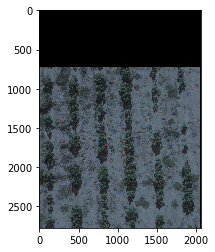

In [15]:
plt.imshow(base_img_warp)

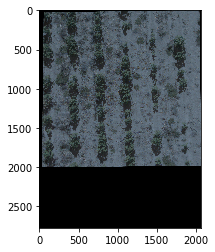

In [16]:
plt.imshow(next_img_warp)

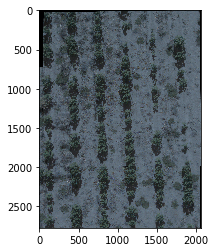

In [17]:
plt.imshow(final_img)